# Plotting bounds on CDFs for piecewise-deterministic Markov processes

### Specify example

In [1]:
example = 4 # Compare CDF bounds to a selection of known asymmetrical lambda values

In [2]:
## Settings that are determined by example number
if (example == 4):
    name2 = 'CDF_Asym_Lambda_'
    name = 'CDF_Bounds'
    sampleSize = 16 # number of lambda combinations to be graphed
    outputfolder2 = '../output/' + name2

### Import Packages


In [3]:
## General purpose
import numpy as np
import os

## Plotting-specific
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib.lines import Line2D

## Set plotting defaults
plt.rc('text', usetex=True)
mathtextsize = 20
plt.rc('font', family='serif', size=16)
plt.rcParams['savefig.bbox'] = 'tight'
frame_skip = 5

# holds colors for lower (colors[m,0]) and upper (colors[m,1]) CDF bounds
colors = [['darkblue', 'royalblue'],['darkred', 'lightcoral']]

### Read in data from file

In [4]:
## Location of C++ output
outputfolder = '../output/' + name
fdtype = np.dtype('f8')

## Grid sizes
gridsize = np.fromfile(outputfolder + '_Gridsizes', 'i4')
nx = gridsize[0]
ns = gridsize[1]
n_modes = gridsize[2]

## Step sizes
config = np.fromfile(outputfolder + '_Stepsizes', fdtype)
dx = config[0]
ds = config[1]
xmin = config[2]
xmax = config[3]
smax = config[4]

## Get data from each mode
bounds_grid = [nx, ns, n_modes, 2] # [ns][nx][mode][upper or lower bound]
W = np.zeros(bounds_grid)

asym_grid = [nx, ns, n_modes, sampleSize]  #[ns][nx][mode][lambda combo]
V = np.zeros(asym_grid)

## create separate figures for each mode
for m in range(n_modes):
    modename = outputfolder + str(m)

    ## Load data for CDF bounds
    CDFUpper = np.fromfile(modename + '_CDF_UpperBound', fdtype)
    CDFLower = np.fromfile(modename + '_CDF_LowerBound', fdtype)
    W[:,:,m,1] = CDFUpper.reshape(nx,ns)
    W[:,:,m,0] = CDFLower.reshape(nx,ns)

    ## Load data for desired combinations of lambdas
    lambda1 = 1.00
    lambda2 = 1.00
    k=0
    for i in range(4):
        for j in range(4):
            modename2 = outputfolder2 + str(lambda1+ i) + "_"+ str(lambda2+j) + "_" + str(m)
            CDFAsym = np.fromfile(modename2 + '_CDF', fdtype)
            V[:,:,m,k] = CDFAsym.reshape(nx,ns)
            k+=1

In [5]:
## Figures will be saved to Ex1/... or Ex2/...
## This code creates this directory if it does not already exist
write_directory = 'Ex' + str(example)
if not os.path.exists(write_directory):
    os.makedirs(write_directory)

# Plotting

### Plot CDFs ($s$ fixed, $x$ varying in each frame)

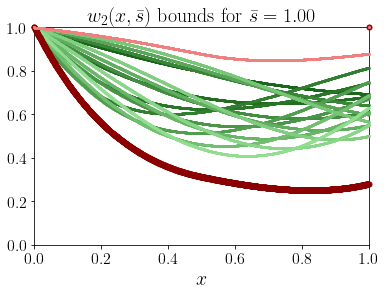

In [6]:
x = np.linspace(xmin,xmax,nx)

## Set key-frames
keyframes = []
for j in [1, 2, 3, 4]:
    keyframes.append(int(j*(ns-1)/8))
n_keyframes = len(keyframes)

for m in range(n_modes):
    ## Create figure
    plt.close()
    fig, ax = plt.subplots()
    ax.set_autoscale_on(False)
    
    ## Initial plots
    asym = [None]*sampleSize
    for j in range(sampleSize):
        d = j/float(sampleSize*2)
        asym[j] = ax.plot(x,V[:,0,m,j],marker ='o', color = (0.1 + d,0.4 + d,0.1 + d), ls = 'None', fillstyle='full', mec=(0.1 + d, 0.4 + d, 0.1 + d), alpha=0.7,ms=2,clip_on=False,zorder=100)[0]

    lower = ax.plot(x,W[:,0,m,0],marker ='o', color = colors[m][0], ls = 'None', fillstyle='full', mec=colors[m][0], alpha=1,ms=5,clip_on=False,zorder=100)[0]
    upper = ax.plot(x,W[:,0,m,1],marker ='o', color = colors[m][1], ls = 'None', fillstyle='full', mec=colors[m][1], alpha=1,ms=2,clip_on=False,zorder=101)[0]
    ax.set_xlabel('$x$', fontsize=mathtextsize)
    ax.set_title(r'$w_{:01d}(x,\bar{{s}})$ bounds for $\bar{{s}} = {:0.2f}$'.format(m+1,0), fontsize=mathtextsize)

    ## Animation function
    def draw_frame(i):
        ## Draw next frames
        s = i * ds
        lower.set_ydata(W[:,i,m,0])
        upper.set_ydata(W[:,i,m,1])
        for j in range(sampleSize):
            asym[j].set_ydata(V[:,i,m,j])


        ax.set_title(r'$w_{:d}(x,\bar{{s}})$ bounds for $\bar{{s}} = {:0.2f}$'.format(m+1,s), fontsize=mathtextsize)

        ## Return iterable of artist objects
        return [lower,upper, asym]

    ## Save key-frames
    for j in range(n_keyframes):
        draw_frame(keyframes[j])
        fig.savefig(write_directory + '/' + name2 + str(j) +'_mode'+str(m+1)+'.png', dpi=300)
        fig.savefig(write_directory + '/' + name2 + str(j) +'_mode'+str(m+1)+'.pdf')

### Create CDF bound graphs ($x$ fixed, $s$ varying)

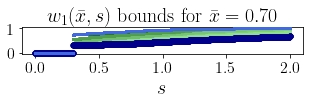

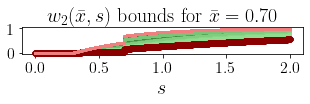

In [7]:
## create separate figures for each mode
for m in range(n_modes):
    ## starting positions to generate CDF bounds for
    xList = [0.3, 0.7]

    ## rearrange arrays to produce CDF data structures
    x2 = np.linspace(0, smax, ns)
    W2 = np.transpose(W, (1, 0, 2, 3))

    V2 = np.transpose(V, (1, 0, 2, 3))
    asym2 = [None]*sampleSize

    fig2, ax2 = plt.subplots()
    ax2.set_autoscale_on(True)

    ## Chose an arbitrary nonzero initial index (here we chose 100) to give the plots the correct size
    for k in range(sampleSize):
        d = k/float(sampleSize*2)
        asym2[k] = ax2.plot(x2,V2[:,100,m,k],marker ='o', color = (0.1 + d,0.4 + d,0.1 + d), ls = 'None', fillstyle='full', mec=(0.1 + d, 0.4 + d, 0.1 + d), alpha=0.7,ms=2,clip_on=False,zorder=100)[0]
    lower2 = ax2.plot(x2,W2[:,100,m,0],marker ='o', color = colors[m][0], ls = 'None', fillstyle='full', mec=colors[m][0], alpha=1,ms=5,clip_on=False,zorder=100)[0]
    upper2 = ax2.plot(x2,W2[:,100,m,1],marker ='o', color = colors[m][1], ls = 'None', fillstyle='full', mec=colors[m][1], alpha=1,ms=2,clip_on=False,zorder=101)[0]

    for x0 in xList:
        idx = int(nx * x0)
        lower2.set_ydata(W2[:,idx,m,0])
        upper2.set_ydata(W2[:,idx,m,1])

        for k in range(sampleSize):
            asym2[k].set_ydata(V2[:,idx,m,k])

        ax2.set_xlabel(r'$s$', fontsize=mathtextsize)
        ax2.set_title(r'$w_{:d}(\bar{{x}},s)$ bounds for $\bar{{x}} = {:0.2f}$'.format(m+1, x0), fontsize=mathtextsize)
        fig2.savefig(write_directory + '/' + name2 + str(x0).replace('.', '') +'_mode'+str(m+1)+'-CDF.pdf')
        fig2.savefig(write_directory + '/' + name2 + str(x0).replace('.', '') +'_mode'+str(m+1)+'-CDF(1).png', dpi=300)

    plt.tight_layout()